In [14]:
from mainnet_launch.destinations import DestinationDetails, get_destination_details

In [ ]:
import streamlit as st
import pandas as pd


from mainnet_launch.constants import AutopoolConstants, CACHE_TIME, eth_client
from mainnet_launch.constants import BAL_ETH, AUTO_ETH, AUTO_LRT
from mainnet_launch.lens_contract import get_pools_and_destinations_call
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks
from mainnet_launch.destinations import DestinationDetails, get_destination_details
from mainnet_launch.data_fetching.get_state_by_block import build_blocks_to_use


def _fetch_destination_depeg_details(autopool: AutopoolConstants, blocks) -> pd.Series:
    """
    Returns a dataframe with one column `nav_per_share_if_no_discount` for each block in blocks.
    """
    # details = [d for d in get_destination_details() if d.autopool == autopool]
    # # autopoolNav in Idle df
    # lp_token_addresss_to_name = {d.lpTokenAddress: d.vault_name for d in details if d.lpTokenAddress is not None}

    pool_and_destinations_df = get_raw_state_by_blocks([get_pools_and_destinations_call()], blocks)

    def _extract_assset_level_data(row: dict):

        for a, destination_list in zip(row["autopools"], row["destinations"]):

            print("")
            if a["poolAddress"].lower() == autopool.autopool_eth_addr.lower():
                totalETH_in_idle = a["totalIdle"] / 1e18
                total_shares = a["totalSupply"] / 1e18

                totalAssets = a["totalAssets"] / 1e18
                discount_data = {}
                assets_held_eth_value_data = {"WETH": totalETH_in_idle}
                assets_held_eth_less_discount = {"WETH": totalETH_in_idle}
                actual_nav = totalETH_in_idle
                scaled_nav = totalETH_in_idle
                for dest in destination_list:
                    discounts = [float(lst_data["discount"] / 1e18) for lst_data in dest["lstStatsData"]]
                    token_symbols = [t["symbol"] for t in dest["underlyingTokenSymbols"]]
                    # reserves in ETH are using the root price oracle
                    valueHeldInEth = [float(t["valueHeldInEth"] / 1e18) for t in dest["underlyingTokenValueHeld"]]

                    # debtValueHeldByVault what is
                    if sum(valueHeldInEth) > 0:
                        print(dest)

                        print("---")

                    for t, d, v in zip(token_symbols, discounts, valueHeldInEth):
                        # if valueHeldInEth[0] >0:
                        # print('----')
                        # print(t, d, v)
                        # debtValueHeldByVault = dest['debtValueHeldByVault'] /1e18
                        # maxDebtValue = dest['maxDebtValue'] /1e18
                        # minDebtValue = dest['minDebtValue'] /1e18
                        # print(f'{dest["lpTokenName"]=}')
                        # print(f'{debtValueHeldByVault=}')
                        # print(f'{maxDebtValue=}')
                        # print(f'{minDebtValue=}')
                        # total_underlyingTokenValueHeld = sum(valueHeldInEth)
                        # print(f'{total_underlyingTokenValueHeld=}')
                        # reserves_in_ETH =  [float(t / 1e18) for t in dest["reservesInEth"]]
                        # print(f"{reserves_in_ETH=}")

                        # print(f"{token_symbols=}")
                        # print('----')

                        discount_data[t] = d
                        scaled_value = v / (1 - d)
                        if t not in assets_held_eth_value_data:
                            assets_held_eth_value_data[t] = v
                        else:
                            assets_held_eth_value_data[t] += v

                        if t not in assets_held_eth_less_discount:
                            assets_held_eth_less_discount[t] = scaled_value
                        else:
                            assets_held_eth_less_discount[t] += scaled_value
                        actual_nav += v
                        scaled_nav += scaled_value

        # actual_nav = sum([v for k, v in assets_held_eth_value_data.items()])
        # nav_less_discounts = sum([v for k, v in assets_held_eth_less_discount.items()])

        all_data = {
            "total_shares": total_shares,
            "actual_nav": actual_nav,
            "scaled_nav": scaled_nav,
            "totalETH_in_idle": totalETH_in_idle,
            "totalAssets": totalAssets,
        }
        for k, v in discount_data.items():
            all_data[k + "_discount"] = v

        for k, v in assets_held_eth_value_data.items():
            all_data[k + "_actual_eth_value"] = v

        for k, v in assets_held_eth_less_discount.items():
            all_data[k + "_eth_value_backed_out_discount"] = v

        return all_data

    asset_level_df = pd.DataFrame.from_records(
        pool_and_destinations_df["getPoolsAndDestinations"].apply(_extract_assset_level_data),
        index=pool_and_destinations_df.index,
    )

    return asset_level_df


first_few_blocks_with_rebalances = [20765628, 20769006, 20774007]
asset_level_df = _fetch_destination_depeg_details(
    BAL_ETH,
    [
        first_few_blocks_with_rebalances[0] - 1,
        first_few_blocks_with_rebalances[0],
        first_few_blocks_with_rebalances[0] + 1,
    ],
)
actual_value_cols = [c for c in asset_level_df.columns if "_actual_eth_value" in c]
discount_cols = [
    c for c in asset_level_df.columns if ("_discount" in c) and ("_eth_value_backed_out_discount" not in c)
]
value_less_discount_cols = [c for c in asset_level_df.columns if "_eth_value_backed_out_discount" in c]
asset_level_df[actual_value_cols]

2024-11-08 09:23:52.904 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-11-08 09:23:52.907 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-11-08 09:23:52.909 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager







{'vaultAddress': '0x2f7e096a400ded5d02762120b39a3aa4aba072a4', 'exchangeName': 'balancer', 'totalSupply': 119628263027667695059, 'lastSnapshotTimestamp': 1726491827, 'feeApr': 11556551254081640, 'lastDebtReportTime': 1726519295, 'minDebtValue': 121545541426973345841, 'maxDebtValue': 121547094662587723019, 'debtValueHeldByVault': 121546318044780534430, 'queuedForRemoval': False, 'statsIncomplete': False, 'isShutdown': False, 'shutdownStatus': 0, 'autoPoolOwnsShares': 119628263027667695059, 'actualLPTotalSupply': 550999242060607907925, 'dexPool': '0x7761b6e0daa04e70637d81f1da7d186c205c2ade', 'lpTokenAddress': '0x7761b6e0daa04e70637d81f1da7d186c205c2ade', 'lpTokenSymbol': 'rsETH / ETHx', 'lpTokenName': 'Balancer rsETH / ETHx', 'statsSafeLPTotalSupply': 370194595819402759004, 'statsIncentiveCredits': 107, 'compositeReturn': 121441968461610492, 'rewardsTokens': [{'tokenAddress': '0xba100000625a3754423978a60c9317c58a424e3d'}, {'tokenAddress': '0xc0c293ce456ff0ed870add98a0828dd4d2903dbf'

/tmp/ipykernel_176877/680922207.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  asset_level_df  = pd.DataFrame.from_records(


,WETH_actual_eth_value,rETH_actual_eth_value,osETH_actual_eth_value,wstETH_actual_eth_value,cbETH_actual_eth_value,ETHx_actual_eth_value,ezETH_actual_eth_value,weETH_actual_eth_value,rswETH_actual_eth_value,rsETH_actual_eth_value,pxETH_actual_eth_value
timestamp,,,,,,,,,,,
2024-09-16 20:41:23+00:00,505.376299,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2024-09-16 20:41:35+00:00,383.662096,0.0,0.0,0.0,0.0,59.415756,0.0,0.0,0.0,62.131339,0.0
2024-09-16 20:41:47+00:00,383.662096,0.0,0.0,0.0,0.0,59.415756,0.0,0.0,0.0,62.131339,0.0


In [ ]:


{
    "vaultAddress": "0x2f7e096a400ded5d02762120b39a3aa4aba072a4",
    "exchangeName": "balancer",
    "totalSupply": 119628263027667695059,
    "lastSnapshotTimestamp": 1726491827,
    "feeApr": 11556551254081640,
    "lastDebtReportTime": 1726519295,
    "minDebtValue": 121545541426973345841,
    "maxDebtValue": 121547094662587723019,
    "debtValueHeldByVault": 121546318044780534430,
    "queuedForRemoval": False,
    "statsIncomplete": False,
    "isShutdown": False,
    "shutdownStatus": 0,
    "autoPoolOwnsShares": 119628263027667695059,
    "actualLPTotalSupply": 550999242060607907925,
    "dexPool": "0x7761b6e0daa04e70637d81f1da7d186c205c2ade",
    "lpTokenAddress": "0x7761b6e0daa04e70637d81f1da7d186c205c2ade",
    "lpTokenSymbol": "rsETH / ETHx",
    "lpTokenName": "Balancer rsETH / ETHx",
    "statsSafeLPTotalSupply": 370194595819402759004,
    "statsIncentiveCredits": 107,
    "compositeReturn": 121441968461610492,
    "rewardsTokens": [
        {"tokenAddress": "0xba100000625a3754423978a60c9317c58a424e3d"},
        {"tokenAddress": "0xc0c293ce456ff0ed870add98a0828dd4d2903dbf"},
        {"tokenAddress": "0xc0c293ce456ff0ed870add98a0828dd4d2903dbf"},
    ],
    "underlyingTokens": [
        {"tokenAddress": "0xa1290d69c65a6fe4df752f95823fae25cb99e5a7"},
        {"tokenAddress": "0xa35b1b31ce002fbf2058d22f30f95d405200a15b"},
    ],
    "underlyingTokenSymbols": [{"symbol": "rsETH"}, {"symbol": "ETHx"}],
    "lstStatsData": [
        {
            "lastSnapshotTimestamp": 1726510571,
            "baseApr": 21613003974001417,
            "discount": 1317387459837788,
            "discountHistory": (10881, 9240, 11036, 11512, 11913, 10621, 13173, 9187, 9923, 12144),
            "discountTimestampByPercent": 0,
        },
        {
            "lastSnapshotTimestamp": 1726510511,
            "baseApr": 13879953250374994,
            "discount": 1851708954947698,
            "discountHistory": (6259, 7358, 17600, 16392, 19315, 12127, 17683, 4637, 6060, 5803),
            "discountTimestampByPercent": 0,
        },
    ],
    "underlyingTokenValueHeld": [{"valueHeldInEth": 62131338669786075127}, {"valueHeldInEth": 59415755992801647935}],
    "reservesInEth": (286172511819763966310, 273664731811077602868),
    "statsPeriodFinishForRewards": (1726794539, 1726794539, 1726794539),
    "statsAnnualizedRewardAmounts": (22157842855286743632000, 58806914937931017599328, 55047214285714276704000),
}

In [2]:
asset_level_df[
    [
        "ETHx_actual_eth_value",
        "rsETH_actual_eth_value",
        "ETHx_eth_value_backed_out_discount",
        "rsETH_eth_value_backed_out_discount",
        "ETHx_discount",
        "rsETH_discount",
    ]
]

,ETHx_actual_eth_value,rsETH_actual_eth_value,ETHx_eth_value_backed_out_discount,rsETH_eth_value_backed_out_discount,ETHx_discount,rsETH_discount
timestamp,,,,,,
2024-09-16 20:41:23+00:00,0.000000,0.000000,0.000000,0.000000,0.001852,0.001317
2024-09-16 20:41:35+00:00,59.415756,62.131339,59.525981,62.213298,0.001852,0.001317
2024-09-16 20:41:47+00:00,59.415756,62.131339,59.525981,62.213298,0.001852,0.001317


In [3]:
asset_level_df["nav_per_share_from_underlying_value_held"] = (
    asset_level_df["actual_nav"] / asset_level_df["total_shares"]
)
asset_level_df["scaled_nav_per_share_from_underlying_value_held"] = (
    asset_level_df["scaled_nav"] / asset_level_df["total_shares"]
)
# there is some funny business here
asset_level_df[
    [
        "actual_nav",
        "scaled_nav",
        "totalAssets",
        "totalETH_in_idle",
        "total_shares",
        "nav_per_share_from_underlying_value_held",
        "scaled_nav_per_share_from_underlying_value_held",
    ]
]

,actual_nav,scaled_nav,totalAssets,totalETH_in_idle,total_shares,nav_per_share_from_underlying_value_held,scaled_nav_per_share_from_underlying_value_held
timestamp,,,,,,,
2024-09-16 20:41:23+00:00,505.376299,505.376299,505.376299,505.376299,505.376299,1.000000,1.00000
2024-09-16 20:41:35+00:00,505.209191,505.401374,505.208414,383.662096,505.376299,0.999669,1.00005
2024-09-16 20:41:47+00:00,505.209191,505.401374,505.208414,383.662096,505.376299,0.999669,1.00005


In [12]:
asset_level_df = _fetch_destination_depeg_details(
    BAL_ETH,
    [
        first_few_blocks_with_rebalances[1] - 1,
        first_few_blocks_with_rebalances[1],
        first_few_blocks_with_rebalances[1] + 1,
    ],
)
actual_value_cols = [c for c in asset_level_df.columns if "_actual_eth_value" in c]
discount_cols = [
    c for c in asset_level_df.columns if ("_discount" in c) and ("_eth_value_backed_out_discount" not in c)
]
value_less_discount_cols = [c for c in asset_level_df.columns if "_eth_value_backed_out_discount" in c]
asset_level_df[actual_value_cols]



----
rETH -0.000510692712285895 0.0
dest["lpTokenName"]='Balancer rETH Stable Pool'
debtValueHeldByVault=0.0
maxDebtValue=0.0
minDebtValue=0.0
total_underlyingTokenValueHeld=0.0
reserves_in_ETH=[6559.275469992702, 7074.028203782509]
token_symbols=['rETH', 'WETH']
----
----
WETH 0.0 0.0
dest["lpTokenName"]='Balancer rETH Stable Pool'
debtValueHeldByVault=0.0
maxDebtValue=0.0
minDebtValue=0.0
total_underlyingTokenValueHeld=0.0
reserves_in_ETH=[6559.275469992702, 7074.028203782509]
token_symbols=['rETH', 'WETH']
----
----
WETH 0.0 0.0
dest["lpTokenName"]='Balancer osETH/wETH StablePool'
debtValueHeldByVault=0.0
maxDebtValue=0.0
minDebtValue=0.0
total_underlyingTokenValueHeld=0.0
reserves_in_ETH=[12059.167395258897, 8030.660650621448]
token_symbols=['WETH', 'osETH']
----
----
osETH -0.00217898132446952 0.0
dest["lpTokenName"]='Balancer osETH/wETH StablePool'
debtValueHeldByVault=0.0
maxDebtValue=0.0
minDebtValue=0.0
total_underlyingTokenValueHeld=0.0
reserves_in_ETH=[12059.167395258897, 

/tmp/ipykernel_141158/4013392002.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  asset_level_df  = pd.DataFrame.from_records(


,WETH_actual_eth_value,rETH_actual_eth_value,osETH_actual_eth_value,wstETH_actual_eth_value,cbETH_actual_eth_value,ETHx_actual_eth_value,ezETH_actual_eth_value,weETH_actual_eth_value,rswETH_actual_eth_value,rsETH_actual_eth_value,pxETH_actual_eth_value
timestamp,,,,,,,,,,,
2024-09-17 08:02:11+00:00,546.957936,0.0,0.0,0.000000,0.0,64.18808,0.0,0.0,0.0,57.367325,0.0
2024-09-17 08:02:23+00:00,416.708969,0.0,0.0,105.270693,0.0,64.18808,0.0,0.0,0.0,57.367325,0.0
2024-09-17 08:02:35+00:00,416.708969,0.0,0.0,105.270693,0.0,64.18808,0.0,0.0,0.0,57.367325,0.0


In [5]:
105.27069332905545 / 110.94

0.9488975421764507

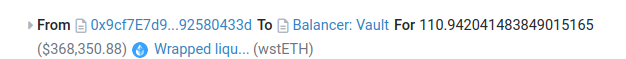 https://etherscan.io/tx/0x0f300d5fb1bfc46d634a9b64f773dbfd73ab9babafc1ee148a9a3d3943e67bbe
this shows that we sent 110.9 wstETH to the balancer vault (I am pretty sure, that it is for liquditity)

however this shows that the amount of reserves in ETH  (in wstETH) we increased 105.270693 was this 

In [6]:
asset_level_df["nav_per_share_from_underlying_value_held"] = (
    asset_level_df["actual_nav"] / asset_level_df["total_shares"]
)
asset_level_df["scaled_nav_per_share_from_underlying_value_held"] = (
    asset_level_df["scaled_nav"] / asset_level_df["total_shares"]
)
# there is some funny business here
asset_level_df[
    [
        "actual_nav",
        "scaled_nav",
        "totalAssets",
        "totalETH_in_idle",
        "total_shares",
        "nav_per_share_from_underlying_value_held",
        "scaled_nav_per_share_from_underlying_value_held",
    ]
]

,actual_nav,scaled_nav,totalAssets,totalETH_in_idle,total_shares,nav_per_share_from_underlying_value_held,scaled_nav_per_share_from_underlying_value_held
timestamp,,,,,,,
2024-09-17 08:02:11+00:00,668.513340,668.707006,668.504254,546.957936,668.726148,0.999682,0.999971
2024-09-17 08:02:23+00:00,643.535066,643.774503,668.456854,411.095864,668.726148,0.962330,0.962688
2024-09-17 08:02:35+00:00,643.535066,643.774503,668.456854,411.095864,668.726148,0.962330,0.962688


In [7]:
643.535066 - 668.513340

-24.978273999999942

we lost 24.9 ETH after the second rebalance, in the sum value valueHeldInEth between destinations, that did not show up in the the change in total Assets?


this drop after the second rebalance comes from valueing (110.9 wstETH, 5.07 WETH) sent to the wstETH:ETH ECLIP balancer destination sent to a as 105.27069332905545, 
()

In [8]:
135.862 - 135.787

0.07499999999998863

In [9]:
# out eth value was 135.862
# in eth value was 135.787 # actual nav ought to dip by 0.0749

In [10]:
some_token_cols = [
    c for c in asset_level_df.columns if any([token in c for token in ["WETH", "rsETH", "ETHx", "wstETH"]])
]
some_token_cols
asset_level_df[some_token_cols]

,WETH_discount,wstETH_discount,ETHx_discount,rsETH_discount,WETH_actual_eth_value,wstETH_actual_eth_value,ETHx_actual_eth_value,rsETH_actual_eth_value,WETH_eth_value_backed_out_discount,wstETH_eth_value_backed_out_discount,ETHx_eth_value_backed_out_discount,rsETH_eth_value_backed_out_discount
timestamp,,,,,,,,,,,,
2024-09-17 08:02:11+00:00,0.0,0.000435,0.001786,0.001372,546.957936,0.000000,64.18808,57.367325,546.957936,0.000000,64.302901,57.446169
2024-09-17 08:02:23+00:00,0.0,0.000435,0.001786,0.001372,416.708969,105.270693,64.18808,57.367325,416.708969,105.316464,64.302901,57.446169
2024-09-17 08:02:35+00:00,0.0,0.000435,0.001786,0.001372,416.708969,105.270693,64.18808,57.367325,416.708969,105.316464,64.302901,57.446169


In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
brea

In [ ]:
from mainnet_launch.constants import BAL_ETH, AUTO_ETH, AUTO_LRT
from mainnet_launch.data_fetching.get_state_by_block import build_blocks_to_use
from mainnet_launch.autopool_diagnostics.nav_if_no_discount import fetch_destination_totalEthValueHeldIfNoDiscount
from mainnet_launch.autopool_diagnostics.fetch_nav_per_share import _fetch_all_all_pool_nav_per_share

discount_allocation_df = fetch_destination_totalEthValueHeldIfNoDiscount(BAL_ETH, blocks)
nav_per_share_df = _fetch_all_all_pool_nav_per_share(blocks)

from mainnet_launch.destination_diagnostics.fetch_destination_summary_stats import fetch_destination_summary_stats

uwcr_df, allocation_df, compositeReturn_out_df, total_nav_series, summary_stats_df, priceReturn_df = (
    fetch_destination_summary_stats(blocks, BAL_ETH)
)
nav_per_share_df

In [ ]:
nav_df = discount_allocation_df[["nav_per_share_if_no_discount"]].copy()
nav_df["nav_per_share"] = nav_per_share_df["balETH"]
px.line(nav_df)

this makes me think it is an error, or we held mostly somethin gtrading at a preimum on the 17th

In [ ]:
early_discount_df = discount_allocation_df[
    (discount_allocation_df.index > "9-16-2024") & (discount_allocation_df.index < "9-20-2024")
].round(2)
early_allocation_df = allocation_df[(allocation_df.index > "9-16-2024") & (allocation_df.index < "9-20-2024")].round(2)

for col in early_allocation_df.columns:
    if col in early_discount_df.columns:
        df = pd.concat([early_discount_df[col], early_allocation_df[col]], axis=1)
        df.columns = ["less discount", "with_discount"]

        if early_discount_df[col].sum() > 0:
            px.line(df, title=col).show()
    else:
        print(col)

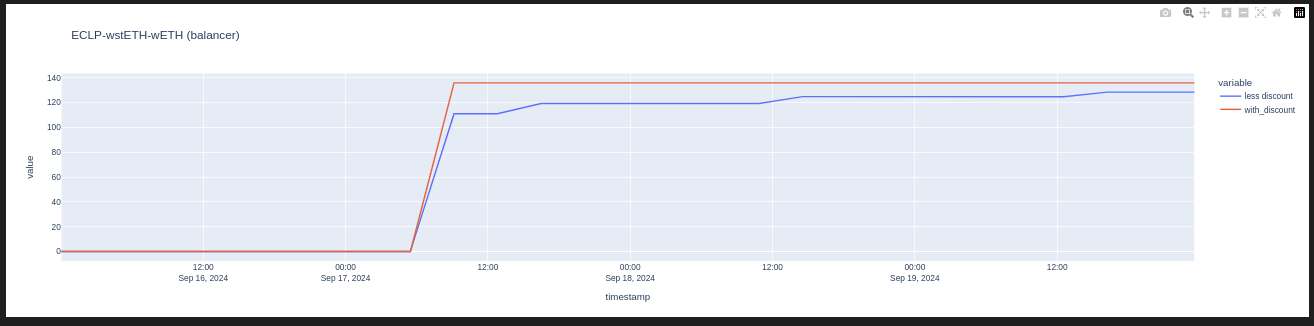

did one of these trade at a premium here?

In [ ]:
from mainnet_launch.constants import AutopoolConstants, CACHE_TIME, eth_client
from mainnet_launch.lens_contract import get_pools_and_destinations_call
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks
from mainnet_launch.destinations import DestinationDetails, get_destination_details

details = [d for d in get_destination_details() if d.autopool == BAL_ETH]
# autopoolNav in Idle df
lp_token_addresss_to_name = {d.lpTokenAddress: d.vault_name for d in details if d.lpTokenAddress is not None}

pool_and_destinations_df = get_raw_state_by_blocks([get_pools_and_destinations_call()], blocks)
pool_and_destinations_df

In [ ]:
def _extract_asset_discounts(row):
    symbol_to_discount = {}

    for destinations in row["destinations"]:
        for dest in destinations:
            symbols = [d["symbol"] for d in dest["underlyingTokenSymbols"]]
            discounts = [round(100 * d["discount"] / 1e18, 4) for d in dest["lstStatsData"]]
            for s, d in zip(symbols, discounts):
                if s in symbol_to_discount:
                    if symbol_to_discount[s] != d:
                        raise ValueError("discount and symbol different")
                else:
                    symbol_to_discount[s] = d
    return symbol_to_discount


lst_discounts = pd.DataFrame.from_records(
    pool_and_destinations_df["getPoolsAndDestinations"].apply(_extract_asset_discounts),
    index=pool_and_destinations_df.index,
)
px.line(lst_discounts)

In [ ]:
early_discount_df = discount_allocation_df[
    (discount_allocation_df.index > "9-16-2024") & (discount_allocation_df.index < "9-20-2024")
].round(2)
early_allocation_df = allocation_df[(allocation_df.index > "9-16-2024") & (allocation_df.index < "9-20-2024")].round(2)


balancer_our_allocation_with_and_without_lst_discounts = pd.concat(
    [early_discount_df["ECLP-wstETH-wETH (balancer)"], early_allocation_df["ECLP-wstETH-wETH (balancer)"]], axis=1
)
balancer_our_allocation_with_and_without_lst_discounts.columns = ["remove_discount", "actual_value"]

px.line(balancer_our_allocation_with_and_without_lst_discounts)

In [ ]:
recent_weETH_discounts = lst_discounts[(lst_discounts.index > "9-16-2024") & (lst_discounts.index < "9-20-2024")].round(
    2
)
# I feel like something is wrong here, why is the actual value less then the value reduced the disoucnt
px.line(recent_weETH_discounts[["weETH", "wstETH"]])

In [ ]:
def fetch_destination_eth_value_held_in_each_token(autopool: AutopoolConstants, blocks) -> pd.Series:
    details = [d for d in get_destination_details() if d.autopool == autopool]
    # autopoolNav in Idle df
    lp_token_addresss_to_name = {d.lpTokenAddress: d.vault_name for d in details if d.lpTokenAddress is not None}

    pool_and_destinations_df = get_raw_state_by_blocks([get_pools_and_destinations_call()], blocks)

    def _extract_eth_value_of_underlying_assets_held(row: dict):
        eth_value_of_assets_held = {}

        for a, destination_list in zip(row["autopools"], row["destinations"]):
            if a["poolAddress"].lower() == autopool.autopool_eth_addr.lower():
                # overestimate because we hold more of the discounted asset than if the price was at peg
                # The invarients have the LP always holding more of the less valueable asset

                eth_value_of_assets_held["WETH"] = a["totalIdle"] / 1e18

                for dest in destination_list:
                    symbols = [d["symbol"] for d in dest["underlyingTokenSymbols"]]
                    valueHeldInEth = [t["valueHeldInEth"] / 1e18 for t in dest["underlyingTokenValueHeld"]]

                    for s, v in zip(symbols, valueHeldInEth):
                        if s in eth_value_of_assets_held:
                            eth_value_of_assets_held[s] += v

                        else:
                            eth_value_of_assets_held[s] = v
        return eth_value_of_assets_held

    eth_value_per_asset_df = pd.DataFrame.from_records(
        pool_and_destinations_df["getPoolsAndDestinations"].apply(_extract_eth_value_of_underlying_assets_held),
        index=pool_and_destinations_df.index,
    )

    return eth_value_per_asset_df


eth_value_per_asset_df = fetch_destination_eth_value_held_in_each_token(BAL_ETH, blocks)
eth_value_per_asset_df

In [ ]:
early_eth_value_per_asset_df = eth_value_per_asset_df[
    (eth_value_per_asset_df.index > "9-16-2024") & (eth_value_per_asset_df.index < "9-20-2024")
].round(2)
px.line(early_eth_value_per_asset_df[["weETH"]])

In [ ]:
# somethign is wrong